In [1]:
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
from optparse import OptionParser
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt


from scipy.sparse.linalg import svds
import utils

from string import punctuation
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
import nltk

try:
    import cPickle as pickle
except ImportError:
    import pickle

In [2]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True,random_state=42)

In [3]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

7882 documents
8 categories


In [4]:
# stopping word

stop_words_skt = text.ENGLISH_STOP_WORDS

nltk.download('stopwords' )
stop_words_en = stopwords.words('english')

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuangyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
vectorizer = TfidfVectorizer(min_df=3, stop_words=combined_stopwords) 
X = vectorizer.fit_transform(dataset.data) # TF 

tfidf_transformer = TfidfTransformer()
X_tfidf  = tfidf_transformer.fit_transform(X)#TFIDF

## Problem 1

In [11]:
X_tfidf = pickle.load(open("X_tfidf.dat", "rb"))

In [6]:

print('The size of TF/TFIDF: ',X_tfidf.shape)


The size of TF/TFIDF:  (7882, 27743)


In [7]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100,random_state=42)
print("Clustering sparse data with :\n  %s" % km)
t0 = time()
km.fit(X_tfidf)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with :
  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
done in 64.727s


In [8]:
labels = dataset.target
labels = (labels >3)

utils.cluster_score(labels,km.labels_,p = True)

Homogeneity: 0.264
Completeness: 0.344
V-measure: 0.298
Adjusted Rand-Index: 0.191
mutual_info_score: 0.183


[0.2636912573942426,
 0.34385330270683967,
 0.29848381733462964,
 0.19060488852725122,
 0.1827645933987022]

Confusion matrix, without normalization
[[3901    2]
 [2218 1761]]


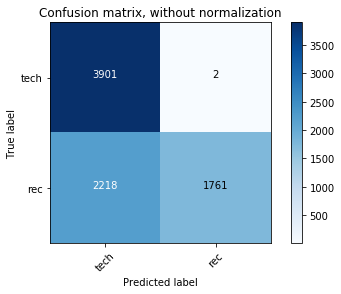

In [9]:
cnf_matrix = metrics.confusion_matrix(labels, km.labels_)
utils.plot_confusion_matrix(cnf_matrix, classes=['tech','rec'],
                      title='Confusion matrix, without normalization')

## Problem 3
-----------
### 1)


In [33]:
# np.random.seed(seed=0)

In [34]:
SVD = TruncatedSVD(n_components=1000, random_state=42)
X_LSI = SVD.fit_transform(X_tfidf)
var = SVD.explained_variance_

# save to local
pickle.dump(X_tfidf, open("X_tfidf.dat", "wb"), True)
pickle.dump(X_LSI, open("X_LSI.dat", "wb"), True)
pickle.dump(var, open("var.dat", "wb"), True)

In [35]:
# X_LSI = pickle.load(open("X_LSI.dat","rb"))

Text(0,0.5,'variance')

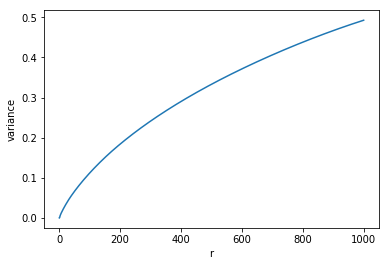

In [36]:
# var = pickle.load(open("var.dat", "rb"))
r_result = [sum(var[:i])for i in range(1001) ]
plt.plot(r_result)
plt.xlabel('r')
plt.ylabel('variance')
# plt.savefig("plots/singular_values_part3.png", format='png')

### 2) LSI

In [50]:
rs = [1,2,3,4,10,50,100,300]

----- 1 -----
Confusion matrix, without normalization
[[2466 1437]
 [2635 1344]]
Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand-Index: 0.001
mutual_info_score: 0.001
----- 2 -----
Confusion matrix, without normalization
[[  15 3888]
 [2182 1797]]
Homogeneity: 0.334
Completeness: 0.392
V-measure: 0.361
Adjusted Rand-Index: 0.292
mutual_info_score: 0.232
----- 3 -----
Confusion matrix, without normalization
[[3902    1]
 [2429 1550]]
Homogeneity: 0.227
Completeness: 0.317
V-measure: 0.264
Adjusted Rand-Index: 0.147
mutual_info_score: 0.157
----- 4 -----
Confusion matrix, without normalization
[[   2 3901]
 [1512 2467]]
Homogeneity: 0.219
Completeness: 0.310
V-measure: 0.257
Adjusted Rand-Index: 0.139
mutual_info_score: 0.152
----- 10 -----
Confusion matrix, without normalization
[[   2 3901]
 [1643 2336]]
Homogeneity: 0.242
Completeness: 0.328
V-measure: 0.278
Adjusted Rand-Index: 0.165
mutual_info_score: 0.168
----- 50 -----
Confusion matrix, without normalization

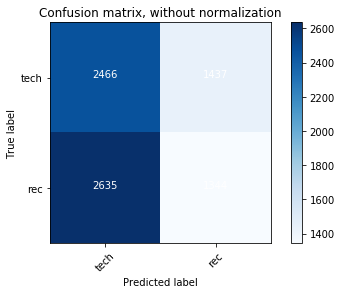

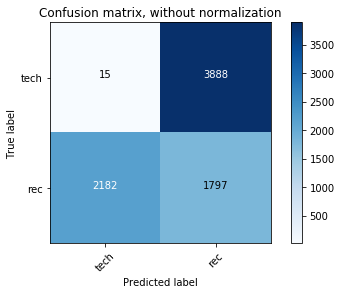

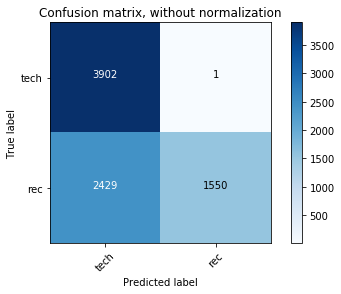

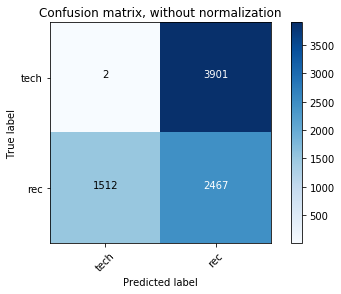

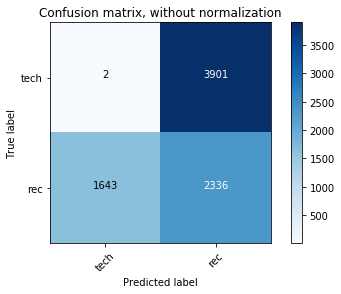

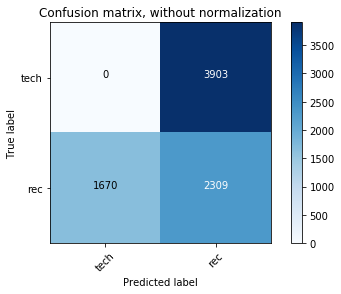

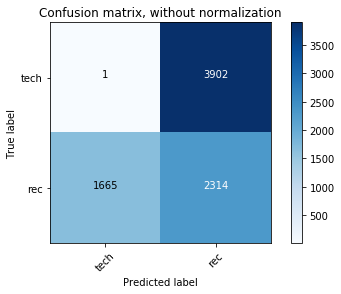

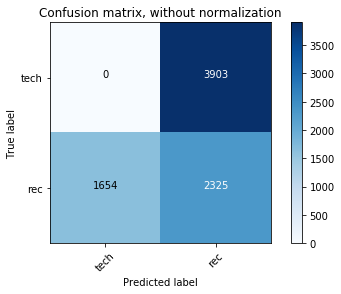

In [51]:
from sklearn.pipeline import make_pipeline
scores_LSI = []

t0 = time()

for r in range(1,301):
    X_truncated = X_LSI[:,:r]
    km_truncated = KMeans(n_clusters=2, init='k-means++',max_iter=100,random_state=42, n_init=30)
    km_truncated.fit(X_truncated)
    
    labels = dataset.target
    labels = (labels>3)
    
    if r in rs:
        print("-"*5,r,"-"*5)
        cnf_matrix = metrics.confusion_matrix(labels, km_truncated.labels_)
        utils.plot_confusion_matrix(cnf_matrix, classes=['tech','rec'],
                      title='Confusion matrix, without normalization')
        
        scores_LSI.append(utils.cluster_score(labels,km_truncated.labels_,p = True))
        
    else:
        scores_LSI.append(utils.cluster_score(labels,km_truncated.labels_,p = False))

print("done in %0.3fs" % (time() - t0))
        

In [52]:
# save to local
pickle.dump(scores_LSI, open("scores_LSI.dat", "wb"), True)
# scores_LSI = pickle.load(open("scores_LSI.dat", "rb"))

Text(0,0.5,'scores')

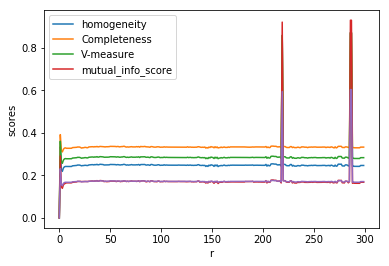

In [53]:
plt.plot(scores_LSI)
plt.legend(['homogeneity','Completeness','V-measure','mutual_info_score'])
plt.xlabel('r')
plt.ylabel('scores')


### 2) NMF

In [54]:
nmf = NMF(n_components=300, init='random', random_state=42)
X_NMF = nmf.fit_transform(X_tfidf)
pickle.dump(X_NMF, open("X_NMF.dat", "wb"), True)

----- 1 -----
Confusion matrix, without normalization
[[3799  104]
 [3979    0]]
Homogeneity: 0.014
Completeness: 0.133
V-measure: 0.025
Adjusted Rand-Index: 0.001
mutual_info_score: 0.009
----- 2 -----
Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002
----- 3 -----
Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002
----- 4 -----
Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002
----- 10 -----
Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002
----- 50 -----
Confusion matrix, without normaliza

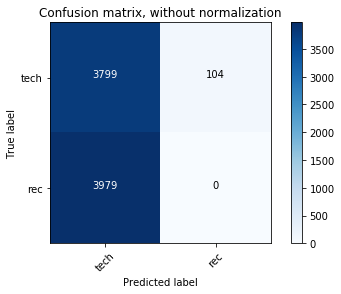

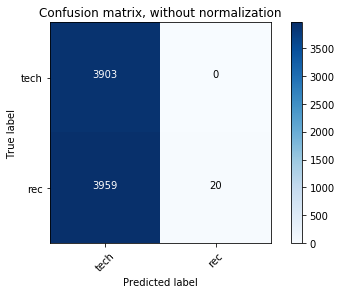

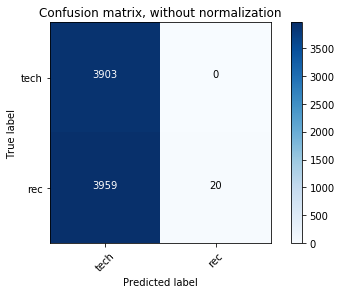

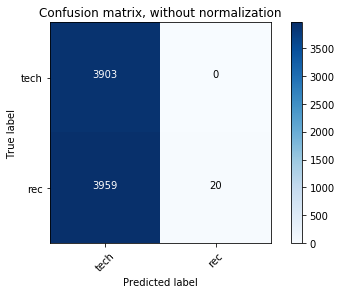

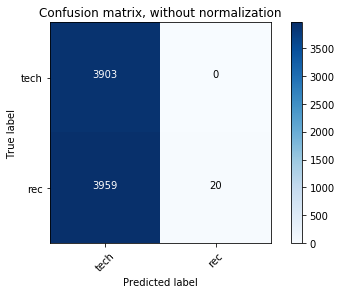

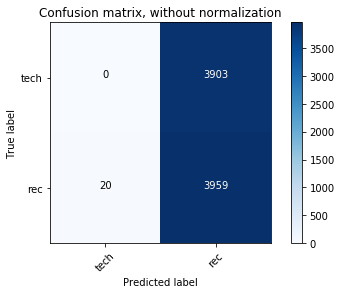

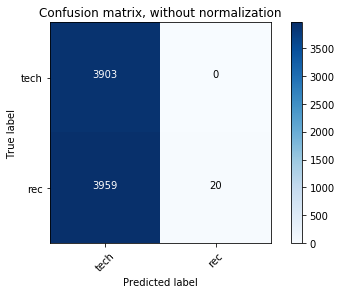

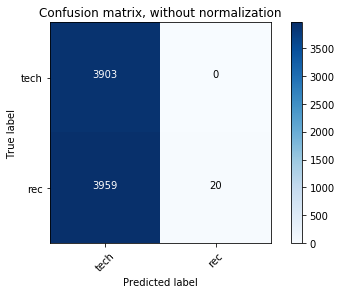

In [55]:
scores_NMF = []
for r in range(1,301):
#     np.random.seed(10)
    X_truncated = X_NMF[:,:r]
    km_truncated = KMeans(n_clusters=2, init='k-means++',random_state=42, n_init=30)
#     t0 = time()
    km_truncated.fit(X_truncated)
#     print("done in %0.3fs" % (time() - t0))
    labels = dataset.target
    labels = (labels >3)
    
    
    if r in rs:
        print("-"*5,r,"-"*5)
        cnf_matrix = metrics.confusion_matrix(labels, km_truncated.labels_)
        utils.plot_confusion_matrix(cnf_matrix, classes=['tech','rec'],
                      title='Confusion matrix, without normalization')        
        scores_NMF.append(utils.cluster_score(labels,km_truncated.labels_,p = True))
        
    else:
        scores_NMF.append(utils.cluster_score(labels,km_truncated.labels_,p = False))


In [56]:
# save to local
pickle.dump(scores_NMF, open("scores_NMF.dat", "wb"), True)
# scores_NMF = pickle.load(open("scores_NMF.dat", "rb"))

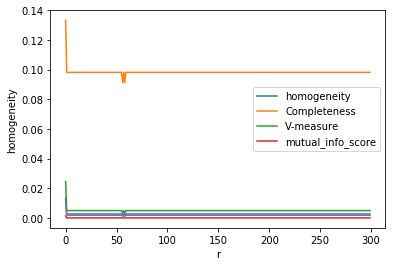

In [57]:
plt.plot(scores_NMF)
plt.xlabel('r')
plt.ylabel('homogeneity')
plt.legend(['homogeneity','Completeness','V-measure','mutual_info_score'])

In [48]:
reduced_dim = 2

svd = TruncatedSVD(n_components=reduced_dim)
normalizer = Normalizer(copy=False)
pipeline = make_pipeline(svd, normalizer)




lsa_train = pipeline.fit_transform(X_train)
kmeans = KMeans(n_clusters=2).fit(lsa_train)


svd = TruncatedSVD(n_components=2)
two_dimensional_lsa = svd.fit_transform(lsa_train)

x1 = two_dimensional_lsa[kmeans.labels_ == 0][:, 0]
y1 = two_dimensional_lsa[kmeans.labels_ == 0][:, 1]

plt.plot(x1,y1,'r+')
x2 = two_dimensional_lsa[kmeans.labels_ == 1][:, 0]
y2 = two_dimensional_lsa[kmeans.labels_ == 1][:, 1]

plt.plot(x2, y2, 'g+')
plt.savefig("plots/clusters_2d.png", format='png')
plt.clf()

labels = all.target // 4
svd = TruncatedSVD(n_components=2)
reduced_X = svd.fit_transform(two_dimensional_lsa)


NameError: name 'X_train' is not defined